In [25]:
import numpy as np
import supervillain as sv
from supervillain.h5 import H5able
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler
from tqdm.notebook import tqdm

In [26]:
N=5
L = sv.lattice.Lattice2D(N)
bootstrap_resampling = 100
configs = 1000

In [27]:
import h5py as h5
storage = 'compare-and-contrast.h5'
# We first remove the storage, so that the examples can run all the way through.
with h5.File(storage, 'w') as f:
    pass

In [28]:
def plot_history(
        axs, index, data,
        label=None,
        bins=31, density=True,
        alpha=0.5, color=None
        ):
    r'''
    axs is a numpy array of at least 2 matplotlib axes.
    In the first goes the Monte Carlo history; in the second goes the corresponding histogram.
    '''
    
    axs[0].plot(index, data, color=color, alpha=alpha)
    axs[1].hist(data, label=label,
            orientation='horizontal',
            bins=bins, density=density,
            color=color, alpha=alpha,)
    
    
def plot(ensemble, ax=None):
    r'''
    Takes an ensemble and an optional set of axes.
    If the axes are not provided, creates a new figure for plotting Monte Carlo histories.
    If the axes are provided, plots Monte Carlo histories on those axes.
    '''
    if ax is None:
        _, ax = plt.subplots(2,2,
            figsize=(10, 6),
            gridspec_kw={'width_ratios': [4, 1], 'wspace': 0},
            sharey='row',
            squeeze=False
        )

    plot_history(ax[0], ensemble.index, ensemble.InternalEnergyDensity)
    plot_history(ax[1], ensemble.index, ensemble.WindingSquared)

    ax[0,0].set_ylabel('U / Λ')
    ax[1,0].set_ylabel('w^2')
    ax[-1,0].set_xlabel('Monte Carlo time')
    
    return ax

In [29]:
def naive_estimate(observable):
    # (mean, uncertainty)
    return (np.mean(observable), np.std(observable) / np.sqrt(len(observable)))  
def bootstrap_estimate(observable):
    # (mean, uncertainty)
    return (np.mean(observable), np.std(observable))

def error_format(estimate):
    mean = estimate[0]
    err  = estimate[1]
    return f'{mean:.3f} ± {err:.3f}'  
def band(ax, estimate, color=None):
    mean = estimate[0]
    err  = estimate[1]
    if color is None:
        color = ax.get_lines()[-1].get_color()
    ax.axhspan(mean-err, mean+err, color=color, alpha=0.5, linestyle='none')

# Plaquette

In [30]:
kappa = 0.5
S = sv.action.Worldline(L, kappa)
p = sv.generator.constraint.PlaquetteUpdate(S)
h = sv.generator.constraint.HolonomyUpdate(S)

G = sv.generator.combining.Sequentially((p, h))  
w = sv.Ensemble(S).generate(configs, G, start='cold', progress=tqdm)

  0%|          | 0/999 [00:00<?, ?it/s]

In [31]:
print(G.report())
print(f'S/Λ    {error_format(naive_estimate(w.InternalEnergyDensity))}')
print(f'dn^2   {error_format(naive_estimate(w.WindingSquared))}')

autocorrelation = max([
    sv.analysis.autocorrelation_time(o)
    for o in (w.InternalEnergyDensity, w.WindingSquared,
              # Holonomies:
              w.configurations.m[:,0].sum(axis=2).sum(axis=1),
              w.configurations.m[:,1].sum(axis=2).sum(axis=1),
             )])

print(f'τ      {autocorrelation}')

There were 2589 single-plaquette proposals accepted of 25000 proposed updates.
    0.103560 acceptance rate
    0.102745 average Metropolis acceptance probability.

There were 675 single-holonomy proposals accepted of 10000 proposed updates.
    0.067500 acceptance rate
    0.066762 average Metropolis acceptance probability.
S/Λ    1.298 ± 0.014
dn^2   0.062 ± 0.003
τ      4


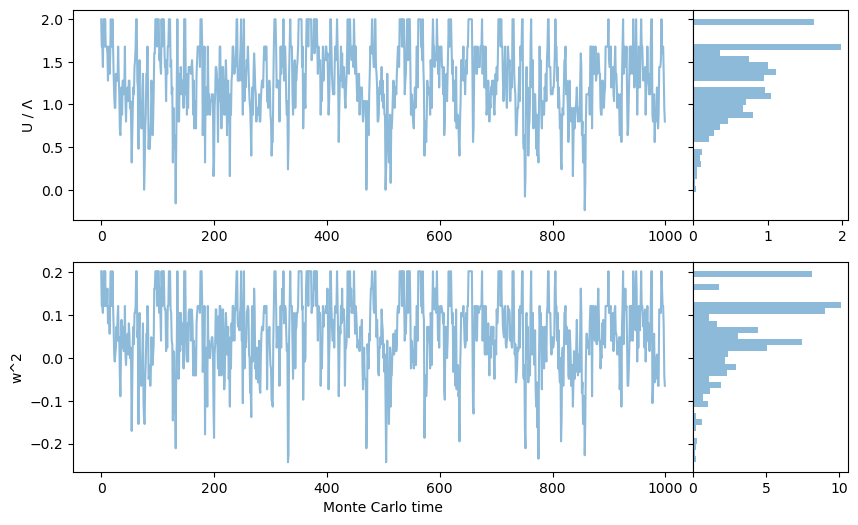

In [32]:
ax = plot(w)

In [33]:
with h5.File(storage, 'a') as f:
    w.to_h5(f.create_group(f'ensemble/{kappa=}'))

In [34]:
w_independent = w.cut(10*autocorrelation).every(5*autocorrelation)
# 10 and 5 are chosen to be 'large'.
# We can calculate the autocorrelation time for the thermalized and decimated samples
independent_autocorrelation = max([
    sv.analysis.autocorrelation_time(o)
    for o in (w_independent.InternalEnergyDensity, w_independent.WindingSquared)])
print(independent_autocorrelation)

2


We can visualize the original and decorrelated samples,

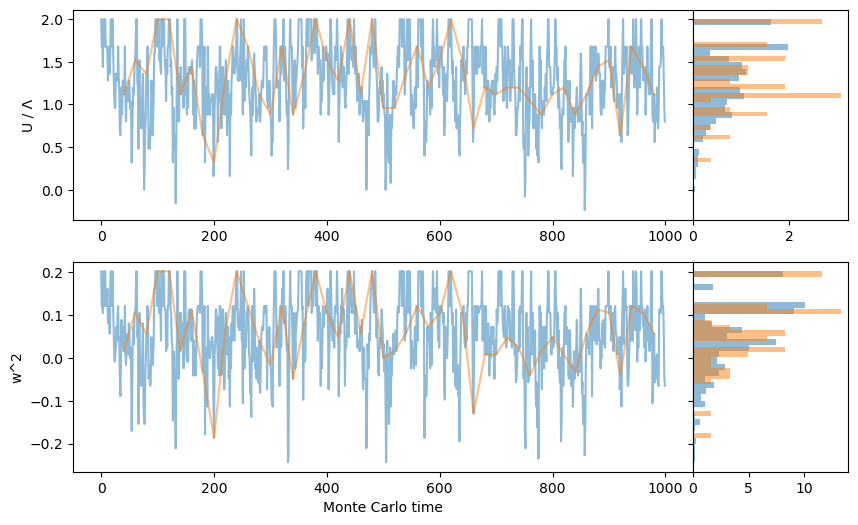

In [35]:
ax = plot(w)
ax = plot(w_independent, ax=ax)

Now, with independent samples we can perform bootstrap estimates.

In [36]:
b = sv.analysis.Bootstrap(w_independent, bootstrap_resampling)

We can just print them prettily

In [37]:
print(f'S/Λ    {error_format(bootstrap_estimate(b.InternalEnergyDensity))}')
print(f'dn^2   {error_format(bootstrap_estimate(b.WindingSquared))}')

S/Λ    1.316 ± 0.056
dn^2   0.064 ± 0.011


or draw the estimates as uncertainty bands

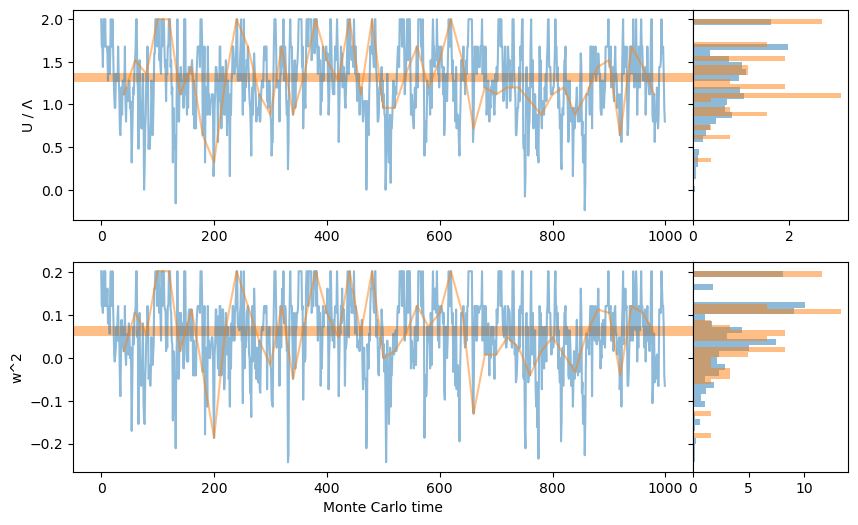

In [38]:
ax = plot(w)
ax = plot(w_independent, ax=ax)

band(ax[0,0], bootstrap_estimate(b.InternalEnergyDensity))
band(ax[1,0], bootstrap_estimate(b.WindingSquared))

In [39]:
with h5.File(storage, 'a') as f:
    b.to_h5(f.create_group(f'/bootstrap/{kappa=}'))

# Worm

In [72]:
kappa = .69
S = sv.action.Worldline(L, kappa)
p = sv.generator.constraint.PlaquetteUpdate(S)
h = sv.generator.constraint.HolonomyUpdate(S)

W = sv.generator.worms.UndirectedWorm(S,1) 
v = sv.Ensemble(S).generate(configs, W, start='cold', progress=tqdm)

  0%|          | 0/999 [00:00<?, ?it/s]

In [73]:
np.ceil(W.avg_length)

6.0

In [74]:
[sv.analysis.autocorrelation_time(v.InternalEnergyDensity),
 sv.analysis.autocorrelation_time(v.InternalEnergyDensitySquared),
 sv.analysis.autocorrelation_time(v.ActionDensity), 
 sv.analysis.autocorrelation_time(v.WindingSquared)]

[5, 5, 5, 4]

# Comparison

Since we wrote both bootstraps to disk we can read them in and compare some observables.

(Of course, we should take the continuum / infinite-volume limit to have a truly fair comparison between different κs!)

In [42]:
with h5.File(storage, 'r') as f:
    V = supervillain.analysis.Bootstrap.from_h5(f[f'/bootstrap/kappa=0.1'])
    W = supervillain.analysis.Bootstrap.from_h5(f[f'/bootstrap/kappa=1.0'])

NameError: name 'supervillain' is not defined

We (approximately) know κ critical

In [ ]:
kappa_critical = 0.740

and can draw it on our figures.

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex='col')

style = {'marker': 'o', 'markerfacecolor': 'none'}

ax[0].errorbar([1/0.1,], *bootstrap_estimate(V.InternalEnergyDensity), **style)
ax[0].errorbar([1/1.0,], *bootstrap_estimate(W.InternalEnergyDensity), **style)

ax[1].errorbar([1/0.1,], *bootstrap_estimate(V.WindingSquared), **style)
ax[1].errorbar([1/1.0,], *bootstrap_estimate(W.WindingSquared), **style)

ax[0].set_xlim(0, 11)

for a in ax:
    a.axvline(1/kappa_critical, color='black')

ax[0].set_ylabel('U/Λ')
ax[1].set_ylabel('w^2')
ax[-1].set_xlabel('1/κ')